## The MTA Discovers Twitter
In early 2018, the MTA made waves by (finally) investing in social media. The agency made it known they had hired a whole new team with the expressed purpose of better customer service in the digital era. So what would that change look like on Twitter?

In [3]:
import pandas as pd
import numpy as np
import os
import re
import datetime as dt
from sklearn.feature_extraction.text import CountVectorizer
import nltk

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.dates as pld
import seaborn as sns
%matplotlib inline

The first step was to download every tweet from 2017 to the present which contained "nyctsubway" (the official Twitter handle for the subways) using [Get Old Tweets](https://github.com/Jefferson-Henrique/GetOldTweets-python), a straightforward Python wrapper for the Twitter API. It was saved as "more_tweets_plus.csv".

In [4]:
df = pd.read_csv('more_tweets_plus.csv')

I used this basic function to remove @ mentions, URL's and MTA employee signatures (which take the form "^XX") from tweets, as well as converting tweets to all lower-case. 

In [5]:
def cleany(tweet):
    tweet = re.sub('@\S+','', tweet)
    tweet = re.sub('\^\S+','', tweet)
    tweet = re.sub('https:\S+','', tweet)
    return tweet.lower()

In [6]:
df['tweet_clean'] = df['text'].map(cleany)

Removing rows with bad or null tweets, then making 'day' feature. 

In [7]:
df2 = df[df.tweet_clean.notnull()]
df2['date'] = pd.to_datetime(df2['date'])
df2['day'] = df2.date.dt.to_period('D').map(lambda x: x.strftime('%Y-%m-%d'))

Importing stop words from NLTK and adding overly prominent words discovered during EDA.

In [8]:
stops = nltk.corpus.stopwords.words('english')
train_words = ['train', 'trains', 'st', 'av', 'http', 'custhelp']
stops = stops+train_words

Functions to efficiently convert tweets into daily word counts.

In [9]:
# pulls 'bag of words' data from one day of tweets
def span_vec_day(day, data=df2, n_grams=(1,1), pro='stem', norm=False, binary=False):
    
    # pulls tweets from 'data' on 'day'
    tweets = data.set_index('day').loc[day]['tweet_clean']
    
    # option to process words by stemming or lemmatizing
    if pro == 'stem':
        t_pro = tweets.map(stem)
    elif pro == 'lem':
        t_pro = tweets.map(lemma)
    else:
        t_pro = tweets
        
    # vectorize using params set in function call
    cv = CountVectorizer(ngram_range=n_grams, stop_words=stops, binary=binary)
    v_tweets = cv.fit_transform(t_pro)
    
    # reconstruct dataframe of word counts
    gram = pd.DataFrame(
        pd.DataFrame(v_tweets.todense(),
                     columns=cv.get_feature_names()).sum().sort_values(ascending=False)
        ).rename(columns={0:'count'})
    
    # option to normalize word counts to length of tweet
    if norm:
        gram['norm'] = gram['count'].map(lambda x: x/len(tweets))
        
    return gram

# from 'start' to 'end returns top 'n' most common words for each day
def vec_day_top_n(n=25, start=False, end=False, data=df2, n_grams=(1,1), pro='stem', norm=False, binary=False):
    
    # indexes 'data' on day column
    d_i = data.set_index('day')
    
    # uses earliest date and latest date if no 'min' or 'max' specified
    if not start:
        start = d_i.index.min()
    if not end:
        end = d_i.index.max()
    
    # initiate collector dataframe
    df = pd.DataFrame()
    
    # iterate through dates in d_i
    for d in d_i.index.unique():
        
        # clear tracked output every ten days
        if d[-1] == '1':
            clear_output()
        
        # run 'span_vec_day' on 'd' with specified params
        gram = span_vec_day(day=d, data=data, n_grams=n_grams, norm=norm, pro=pro, binary=binary)
        
        # return dataframe of top 'n' most common words for each day
        df_gram = pd.DataFrame(gram).reset_index().rename(columns={'index':'word',0:'count'}).iloc[0:n,:]
        
        # create 'date' column
        df_gram['date'] = d
        
        # add to collector df
        df = pd.concat([df, df_gram])
        
        # print date for tracking
        print(d) 
    return df.sort_values('date').reset_index(drop=True)

Pulling some data.

In [10]:
# top 25 1-, 2-, and 3-grams for all dates
top25_daily_ng1to3 = vec_day_top_n(n=25, n_grams=(1,3), pro=None, norm=True)

2017-01-11
2017-01-10
2017-01-09
2017-01-08
2017-01-07
2017-01-06
2017-01-05


In [11]:
# top 100 1-grams for all dates
top100_daily = vec_day_top_n(n=100, pro=None, norm=True, binary=True)

2017-01-11
2017-01-10
2017-01-09
2017-01-08
2017-01-07
2017-01-06
2017-01-05


Functions to plot seaborn regplots (scatter plot + regression line) of word counts by day. 'regplot_words' contains parameters to specify data, specific words or a word range, normalized counts or raw counts, and to add a vertical line to the plot.

'reg9' runs 'regplot_words' for the top `i` to `i+9` words in the provided `data` ie it does a 3x3 grid of regplots.

In [51]:
# regplot of words from vectorized tweets
def regplot_words(i=0, j=3, words=None, data=top100_daily, fig=True, sort_date=False,
              lim=None, line=False, fit=True, norm=False, alpha=0.5):
    
    # if 'norm' use normalized word counts, otherwise use raw counts
    if norm:
        y = 'norm'
    else:
        y = 'count' 
    
    # use word(s) if provided (and convert single word to list) ...
    if words is not None:
        if type(words) == str:
            word_list = [words]
        else:
            word_list = words

    else:
        # if 'sort_date' exists, check if it's formatted right...
        if sort_date != False:
            reg = re.compile('\d{4}-\d{2}-\d{2}')
            if reg.match(sort_date) != None:    
                d_for_word_list = data[data['date'] == sort_date]
        else:
            d_for_word_list = data                
                
        # ... otherwise create word list from i'th to j'th most common words in data'
        word_list = []
        for w in d_for_word_list.groupby(
            'word').sum().sort_values(y, ascending=False).iloc[i:j].reset_index()['word']:
            word_list.append(w)
            
    # pull list of unique dates
    dates = data.loc[:,'date'].unique()
    
    # option to make one big plot instead of multiple, evenly-sized plots
    if fig:
        fig = plt.figure(figsize=(15,7))
        
    # iterate through 'word_list' ...
    for w in word_list:
        
        # create dataframe of word counts by day, filling in missing dates with 0
        d = data[data['word'] == w].sort_values('date')
        counts = {'date':[], y:[]}
        for d1 in dates:
            counts['date'].append(d1)
            if d.loc[:,'date'].str.contains(d1).sum() > 0:
                counts[y].append(d[d['date'] == d1][y].values[0])
            else:
                counts[y].append(0)
                
        # plot word counts by date
        # fit regression line if 'fit_reg'
        plot_df = pd.DataFrame(counts).reset_index()
        sns.regplot(
            data=plot_df, x='index', y=y, fit_reg=fit, scatter_kws=({'alpha':alpha, 'color':'orange'}))
        
        # for scaling x-axis
        l = plot_df['index'].max()
        
        # option to plot a vertical line
        if line:
            plt.axvline(x=line, linestyle=':')
            
#         # add legend
#         plt.legend(labels=word_list)

        # add title
        plt.title(s=w)
        
        # set y-axis for normalized or raw counts
        if norm:
            plt.ylim(-0.1, 1)
        elif lim:
            plt.ylim(-10,lim)
        plt.xlim(-l*.05,l+(l*0.05))
        plt.xlabel('');
    
# a 3x3 subplot of sns_words for i=i*9, j=(i*9)+9
# 'line' 'lim' and 'fit' are are passed to regplot_words

def reg9(i, data=top100_daily, lim=None, line=None, fit=True, norm=True, alpha=0.5, sort_date=False, title=''):
    plt.figure(figsize=(15,15))
    plt.suptitle(t=title, size=17, y=0.93)
    j = i*9
    for n in range(9):
        plt.subplot(3,3,n+1)
        regplot_words(j+n,j+n+1, data=data, fig=False, lim=lim, line=line, fit=fit, norm=norm, alpha=alpha, sort_date=sort_date)

Setting `fit` to 361 because that's 1/1/2018 -- more or less when we expect to see changes in tweet syntax.

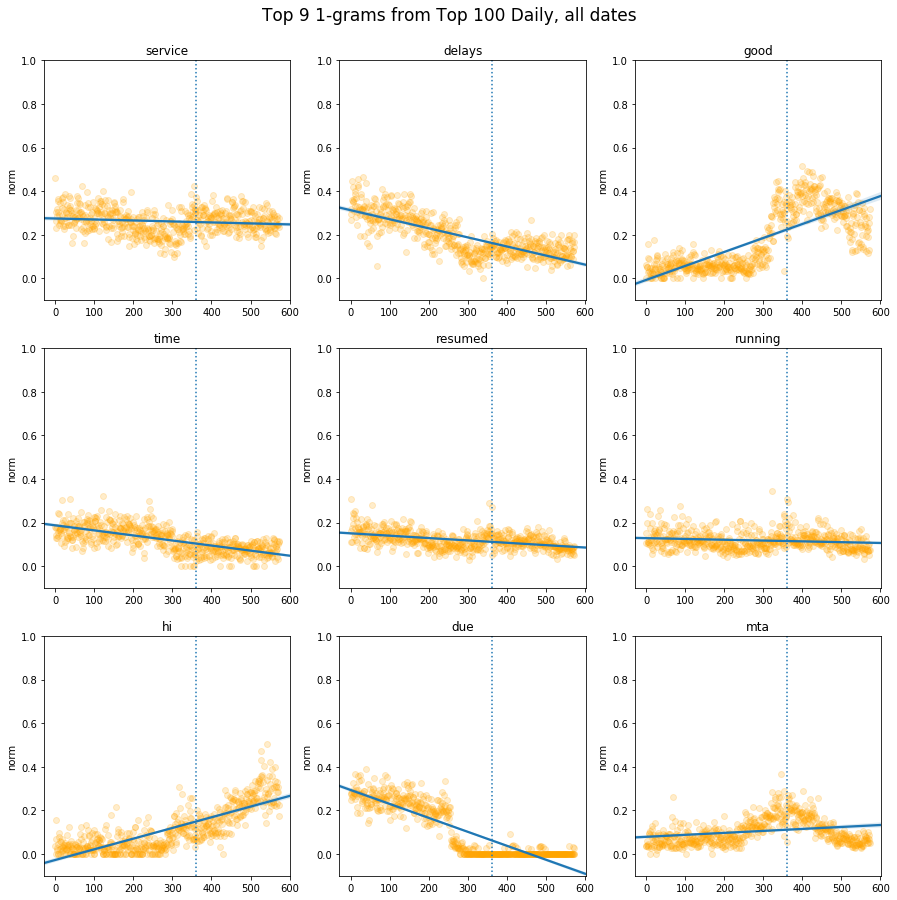

In [53]:
reg9(0, data=top100_daily, norm=True, alpha=0.2, line=361, fit=True, title='Top 9 1-grams from Top 100 Daily, all dates')

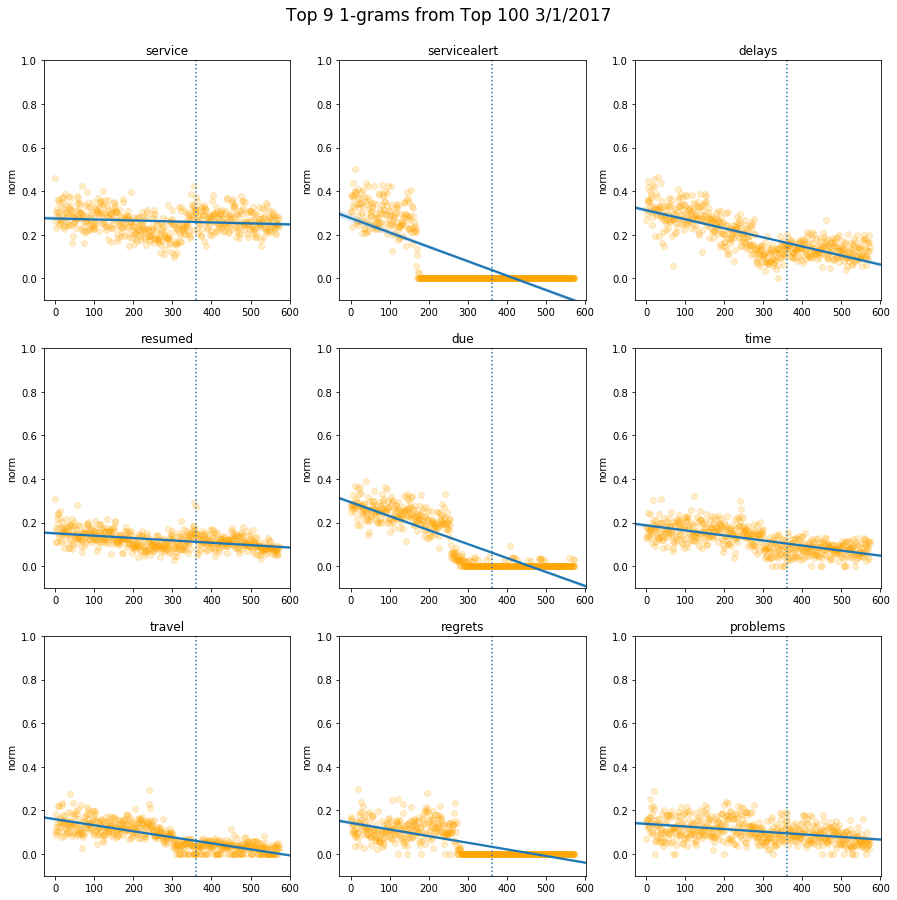

In [54]:
reg9(0, data=top100_daily, norm=True, alpha=0.2, line=361, fit=True, sort_date='2017-03-01', title='Top 9 1-grams from Top 100 3/1/2017')

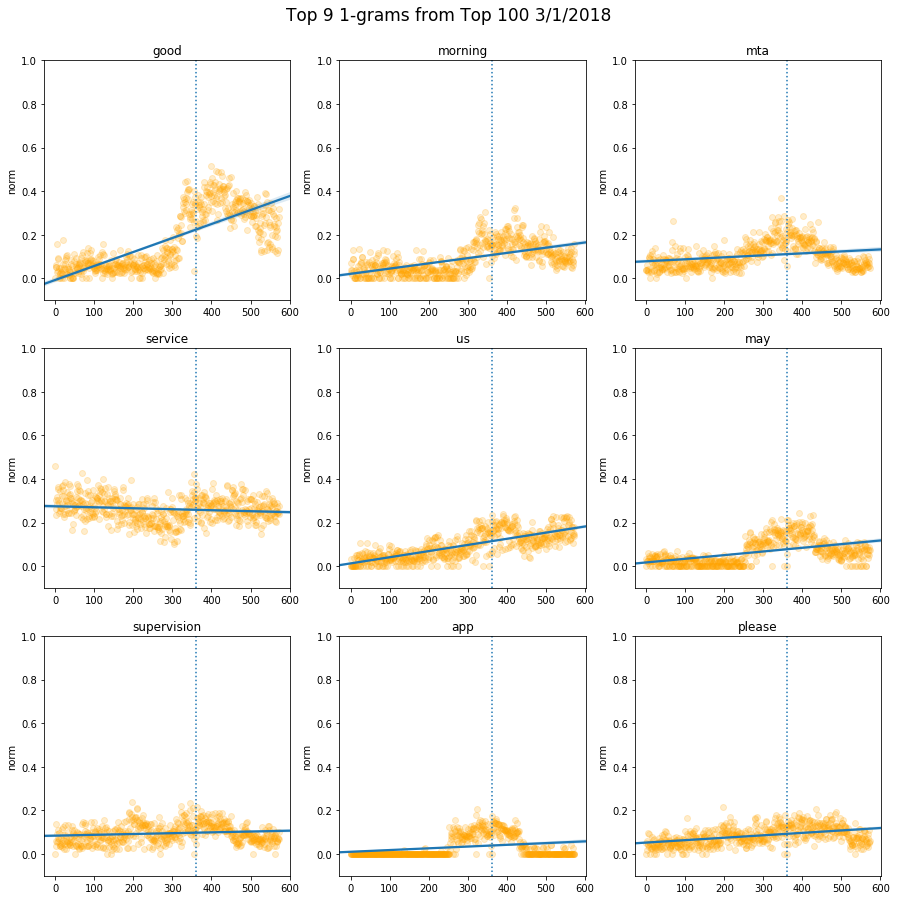

In [55]:
reg9(0, data=top100_daily, norm=True, alpha=0.2, line=361, fit=True, sort_date='2018-03-01', title='Top 9 1-grams from Top 100 3/1/2018')

## Applying the research
This cursory analysis reveals some evident trends in MTA twitter. Use of the term "due" drops off almost entirely after 2018 starts, while "good" and "hi" are on the upswing. More importantly, this is proof of concept. It's anecdotal evidence that we can use this method to look for changes in how the MTA tweets.

Transit journalist Aaron W. Gordon noted that subway alerts about emergency break activations seemed to have increased in the last few months. On June 28th, [the MTA noted](https://twitter.com/NYCTSubway/status/1012343209295536128) that they had a new policy to explicity mention when a train's emergency breaks were set off, as opposed to calling such incidents "mechanical problems". Gordon asked me to see if I could visualize the change in syntax.

Importing tweet search for 'nyctsubway' and 'brakes' from 2017 and 2018.

In [15]:
df = pd.read_csv('brakes.csv')
df['date'] = pd.to_datetime(df['date'])
df['day'] = df.date.dt.to_period('D').map(lambda x: x.strftime('%Y-%m-%d'))
df['auth'] = df['permalink'].map(lambda x: re.search(r'(?<=com\/)\w.+(?=\/status\/)',x)[0])

Importing tweet search for 'nyctsubway' and 'mechanical' from 2017 and 2018.

In [16]:
mech = pd.read_csv('mechanical.csv').dropna()
mech['date'] = pd.to_datetime(mech['date'])
mech['day'] = mech.date.dt.to_period('D').map(lambda x: x.strftime('%Y-%m-%d'))
mech['auth'] = mech['permalink'].map(lambda x: re.search(r'(?<=com\/)\w.+(?=\/status\/)',x)[0])

Marking tweets that contain "breaks were automatically activated" and which contain the stem "activ". Less automated tweets means we have to account for "activate, activated, activation" etc.

In [17]:
brakes_2017_2018 = df[(df.date.dt.year == 2018) | (df.date.dt.year == 2017)]
brakes_2017_2018['bwaa'] = brakes_2017_2018['text'].str.contains('brakes were automatically activated')
brakes_2017_2018['act'] = brakes_2017_2018['text'].str.contains('activ')


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Marking tweets that contain "because of a train with mechanical problems" and "due to a train with mechanical problems".

In [18]:
mech_2017_2018 = mech[(mech.date.dt.year == 2018) | (mech.date.dt.year == 2017)]
mech_2017_2018['mp'] = mech_2017_2018['text'].str.contains('because of a train with mechanical problems')
mp = mech_2017_2018[mech_2017_2018['auth'] == 'NYCTSubway'][['day','mp']].groupby('day').sum().reset_index()
mp['day'] = pd.to_datetime(mp['day'])

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [19]:
due_str = 'due to a train with mechanical problems'
mech_2017_2018['due'] = mech_2017_2018['text'].str.contains(due_str)
due = mech_2017_2018[mech_2017_2018['auth'] == 'NYCTSubway'][['day','due']].groupby('day').sum().reset_index()
due.day = pd.to_datetime(due.day)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Data wrangling for viz purposes.

In [20]:
bwaa = brakes_2017_2018[brakes_2017_2018['auth'] == 'NYCTSubway'][['day','bwaa']].groupby('day').sum().reset_index()

In [21]:
act = brakes_2017_2018[brakes_2017_2018['auth'] == 'NYCTSubway'][['day','act']].groupby('day').sum().reset_index()
act.day = pd.to_datetime(act.day)

In [22]:
bwaa.day = pd.to_datetime(bwaa.day)
for d in [bwaa, due, act]:
    mp = pd.merge(mp, d, how='outer', on='day').fillna(0)
idx = pd.date_range('2017-01-01', '2018-08-05')

df_imputed = mp.set_index('day').reindex(idx, fill_value=0).reset_index()

Plotting the data to show clear trends over time.

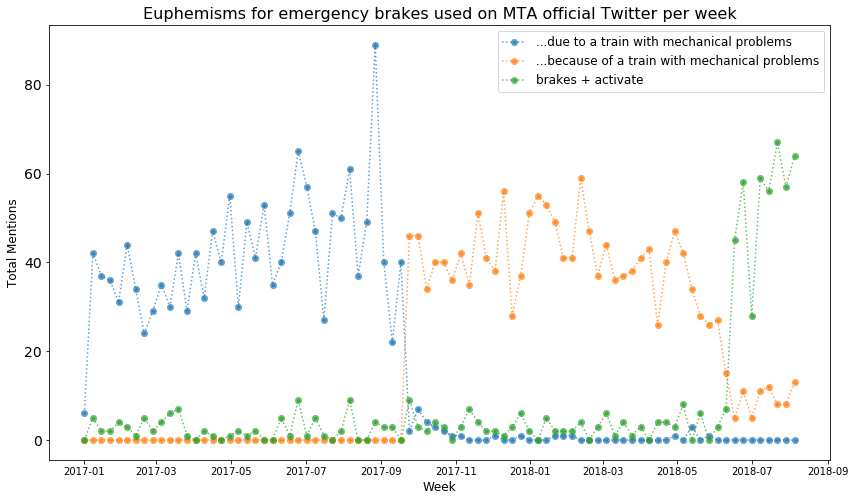

In [23]:
d = df_imputed.set_index('index').resample('W').sum().reset_index()

kwargs = {'linestyle':':', 'marker':'.', 'mew':'4', 'alpha':0.7}

fig = plt.figure(figsize=(14,8))
plt.title(s='Euphemisms for emergency brakes used on MTA official Twitter per week', size=16)
plt.plot_date(data=d, x='index', y ='due', xdate=True, **kwargs)
plt.plot_date(data=d, x='index', y ='mp', xdate=True, **kwargs)
plt.plot_date(data=d, x='index', y ='act', xdate=True, **kwargs)
plt.yticks(size=14)
plt.legend(['...due to a train with mechanical problems','...because of a train with mechanical problems', 'brakes + activate'], fontsize=12)
plt.xlabel('Week', size=12)
plt.ylabel('Total Mentions', size=12);